# Forecasting Hourly Stop-Level Service Intensity

This notebook focuses on building a predictive model to estimate the number of scheduled vehicle departures per stop per hour in Montreal’s transit network.

In other words, the main question we’re trying to answer is:
“How many departures are expected from each stop during a given hour?”

This is a supply-side forecast aimed at predicting how much service the system plans to provide based on GTFS (General Transit Feed Specification) data.

We begin by preparing and transforming schedule-level GTFS data into a modelling-ready format, engineer time-based and stop-specific features, and train a model to forecast hourly departure volumes.

This notebook is part of a broader project that includes analysis, forecasting, and visualizations of Montreal transit data using Python, SQL, and Tableau.

<span style="font-size:22px">**Forecasting Goal and Scope**

The goal of this forecasting task is not to build a comprehensive model over the entire dataset, but rather to demonstrate a practical application of predictive modeling. We focus on a small subset of the data and forecast the number of scheduled departures at each hour of the day.

Given the small size and complexity of the dataset, we intentionally do not deep-dive into model optimization. This includes skipping validation set creation, cross-validation, hyperparameter tuning, or advanced models.

Instead, the objective is to showcase a solid understanding of the prediction pipeline, from data preprocessing and feature engineering to model training and evaluation, using interpretable techniques like Random Forests and clear visualizations.

In [2]:
# Import required libraries
import pandas as pd
import os
#import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### GTFS

The GTFS data overview, the steps for creating the stop-level schedule, and its analyses are fully documented in the **"GTFS _Data_Analysis.ipynb" notebook**. In this notebook, we simply merge and use the prepared data.

In [3]:
# Define the GTFS directory
gtfs_path = "gtfs"

gtfs_files = {
    "routes": "routes.txt",
    "stop_times": "stop_times.txt",
    "stops": "stops.txt",
    "trips": "trips.txt",
    "shapes": "shapes.txt",
    "feed_info": "feed_info.txt",
    "calendar": "calendar.txt",
    "agency": "agency.txt",
    "calendar_dates": "calendar_dates.txt"
}

# Read all GTFS files into a dictionary of DataFrames
gtfs_dfs = {}
for name, file in gtfs_files.items():
    full_path = os.path.join(gtfs_path, file)
    if os.path.exists(full_path):
        gtfs_dfs[name] = pd.read_csv(full_path)
    else:
        gtfs_dfs[name] = pd.DataFrame()

In [4]:
gtfs_dfs.keys()

dict_keys(['routes', 'stop_times', 'stops', 'trips', 'shapes', 'feed_info', 'calendar', 'agency', 'calendar_dates'])

<span style="font-size:18px">**Stop-Level Schedule Construction**

In [5]:
# Required GTFS DataFrames
stop_times = gtfs_dfs["stop_times"]
trips = gtfs_dfs["trips"]
routes = gtfs_dfs["routes"]
stops = gtfs_dfs["stops"]

# Ensure stop_id is a string in both for merging
stop_times["stop_id"] = stop_times["stop_id"].astype(str)
stops["stop_id"] = stops["stop_id"].astype(str)

# Merge stop_times with trips to get trip-level metadata
merged_1 = pd.merge(stop_times, trips, on="trip_id", how="left")

# Merge the result with routes to get route-level info
merged_2 = pd.merge(merged_1, routes, on="route_id", how="left")

# Merge with stops to get stop name and location
full_schedule_df = pd.merge(merged_2, stops, on="stop_id", how="left")

In [6]:
full_schedule_df.head(2)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,direction_id,shape_id,...,route_color,route_text_color,stop_code,stop_name,stop_lat,stop_lon,stop_url,location_type,parent_station,wheelchair_boarding
0,281570788,05:58:00,05:58:00,51095,1,16,25J-H50J000A-80-A,Ouest,1,160088,...,009EE0,FFFFFF,51095,Station Parc (Ogilvy / Hutchison),45.530549,-73.624282,https://www.stm.info/fr/recherche#stq=51095,0,NaN,1
1,281570788,05:59:39,05:59:39,51126,2,16,25J-H50J000A-80-A,Ouest,1,160088,...,009EE0,FFFFFF,51126,Querbes / Jean-Talon,45.528506,-73.623649,https://www.stm.info/fr/recherche#stq=51126,0,NaN,1


**Each row in full_schedule_df represents a single stop at a specific time on a specific trip for a specific route.**

In [7]:
full_schedule_df.shape

(6265018, 28)

In [8]:
full_schedule_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'note_fr', 'note_en', 'agency_id',
       'route_short_name', 'route_long_name', 'route_type', 'route_url',
       'route_color', 'route_text_color', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'stop_url', 'location_type', 'parent_station',
       'wheelchair_boarding'],
      dtype='object')

# Preprocessing for Forecasting

In [9]:
full_schedule_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'note_fr', 'note_en', 'agency_id',
       'route_short_name', 'route_long_name', 'route_type', 'route_url',
       'route_color', 'route_text_color', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'stop_url', 'location_type', 'parent_station',
       'wheelchair_boarding'],
      dtype='object')

In [10]:
full_schedule_df["hour"] = full_schedule_df["departure_time"].str.slice(0,2).astype("int32")

In [11]:
full_schedule_df["hour"].min()

4

In [12]:
full_schedule_df["hour"].max()

30

(24–30 = early morning next day)

In [13]:
# Normalize to standard clock hours (0–23)
full_schedule_df["hour_mod"] = full_schedule_df["hour"] % 24

**hour:** operational hour from GTFS

**hour_mod:** actual time-of-day 

In [14]:
full_schedule_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'note_fr', 'note_en', 'agency_id',
       'route_short_name', 'route_long_name', 'route_type', 'route_url',
       'route_color', 'route_text_color', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'stop_url', 'location_type', 'parent_station',
       'wheelchair_boarding', 'hour', 'hour_mod'],
      dtype='object')

In [15]:
columns_to_drop = ["note_fr", "note_en", "route_url", "route_color", "route_text_color", "stop_url"]

full_schedule_df.drop(columns=columns_to_drop, inplace=True)

In [16]:
# Count number of departures per stop and hour
departures_per_hour = full_schedule_df.groupby(["stop_id", "stop_name", "hour"]).size()\
                                      .reset_index(name="num_departures")

In [17]:
full_schedule_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'agency_id', 'route_short_name',
       'route_long_name', 'route_type', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'location_type', 'parent_station', 'wheelchair_boarding',
       'hour', 'hour_mod'],
      dtype='object')

In [18]:
departures_per_hour.columns

Index(['stop_id', 'stop_name', 'hour', 'num_departures'], dtype='object')

## Exploratory insight: Aggregated View

<span style="font-size:18px">**Goal:**
In this section, we visualize hourly departure patterns for selected high-traffic stops and apply smoothing to highlight overall trends.

In [19]:
top_stops = departures_per_hour.groupby("stop_id")["num_departures"].sum().sort_values(ascending=False).head(3).index

In [20]:
top_stops_df = departures_per_hour[departures_per_hour["stop_id"].isin(top_stops)].sort_values("hour")

In [21]:
top_stops_df.head(3)

,stop_id,stop_name,hour,num_departures
701,36,Station Lionel-Groulx,5,68
80352,54127,Station Henri-Bourassa,5,83
165404,60633,Angrignon / Tours Angrignon,5,122


Smoothing with moving average (window = 3 hours, centered):

For each hour, we take the average of that hour and its two neighbors, one before and one after (symmetric smoothing). We’re smoothing out noise and getting a clear trend line.

In [22]:
# Sort before applying rolling mean
top_stops_df = top_stops_df.sort_values(["stop_id", "hour"])

# Smooth with moving average (window = 3 hours, centered)
top_stops_df["smoothed"] = top_stops_df.groupby("stop_id")["num_departures"].rolling(window=3, center=True)\
                                       .mean().reset_index(level=0, drop=True)

In [23]:
top_stops_df.columns

Index(['stop_id', 'stop_name', 'hour', 'num_departures', 'smoothed'], dtype='object')

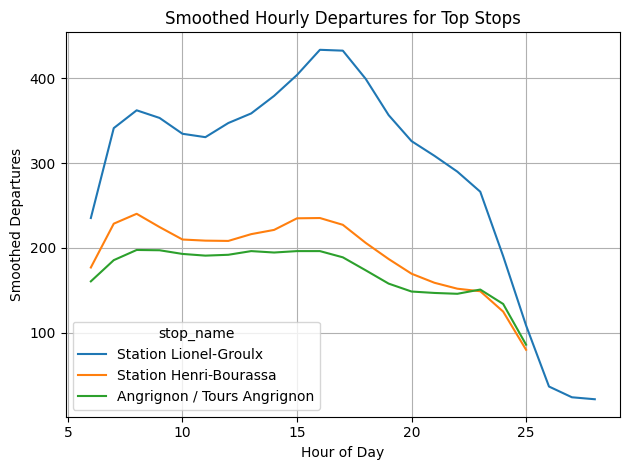

In [24]:
sns.lineplot(data=top_stops_df, x="hour", y="smoothed", hue="stop_name")
plt.title("Smoothed Hourly Departures for Top Stops")
plt.xlabel("Hour of Day")
plt.ylabel("Smoothed Departures")
plt.grid(True)
plt.tight_layout()
plt.show()

## Investigating Top Service Hours per Stop

In [25]:
# Reset index to make sure all columns are accessible
top_stops_df = top_stops_df.reset_index(drop=True)

In [26]:
# Get row indices where num_departures is max per stop_id
max_idx = top_stops_df.groupby("stop_id")["num_departures"].idxmax()

In [27]:
# Find the hour with max departures per stop
busiest_hour = top_stops_df.iloc[max_idx][["stop_id", "stop_name", "hour"]].rename(columns={"hour": "busiest_hour"})

In [28]:
busiest_hour

,stop_id,stop_name,busiest_hour
12,36,Station Lionel-Groulx,17
27,54127,Station Henri-Bourassa,7
51,60633,Angrignon / Tours Angrignon,9


In [29]:
# Merge back into the original DataFrame
top_stops_df = top_stops_df.merge(busiest_hour[["stop_id", "busiest_hour"]], on="stop_id", how="left")

## Heatmap of All Stops vs Hours

In [30]:
# Pivot the data to create a matrix (stops as rows, hours as columns, values are departure counts)
pivot = departures_per_hour.pivot_table(index="stop_name", columns="hour", aggfunc="sum",
                                        values="num_departures").fillna(0)

pivot.head()

hour,4,5,6,7,8,9,10,11,12,13,...,21,22,23,24,25,26,27,28,29,30
stop_name,,,,,,,,,,,,,,,,,,,,,
100e Avenue / Bureau,9.0,31.0,53.0,82.0,67.0,56.0,48.0,45.0,42.0,48.0,...,48.0,48.0,48.0,48.0,42.0,45.0,42.0,27.0,21.0,0.0
10e Avenue / Notre-Dame,3.0,18.0,45.0,56.0,48.0,39.0,48.0,39.0,48.0,45.0,...,48.0,48.0,48.0,66.0,27.0,15.0,0.0,0.0,0.0,0.0
10e Avenue / Provost,0.0,0.0,18.0,24.0,24.0,24.0,15.0,24.0,24.0,24.0,...,24.0,24.0,24.0,27.0,30.0,15.0,0.0,0.0,0.0,0.0
10e Avenue / Saint-Antoine,6.0,24.0,42.0,50.0,48.0,48.0,33.0,45.0,48.0,57.0,...,48.0,48.0,48.0,66.0,27.0,15.0,0.0,0.0,0.0,0.0
10e Avenue / Saint-Louis,0.0,0.0,18.0,24.0,24.0,24.0,24.0,15.0,24.0,24.0,...,24.0,24.0,24.0,33.0,24.0,15.0,0.0,0.0,0.0,0.0


In [31]:
departures_per_hour["stop_id"].nunique()

8790

This is too much data for the heatmap to display clearly, so we limit it to the 30 busiest stops.

In [32]:
# Get top 30 busiest stops
top_stops = departures_per_hour.groupby("stop_name")["num_departures"].sum().sort_values(ascending=False)\
                               .head(30).index

# Filter data
filtered_df = departures_per_hour[departures_per_hour["stop_name"].isin(top_stops)]

# Create pivot for top stops (30)
pivot = filtered_df.pivot_table(
    index="stop_name", columns="hour", values="num_departures", aggfunc="sum"
).fillna(0)

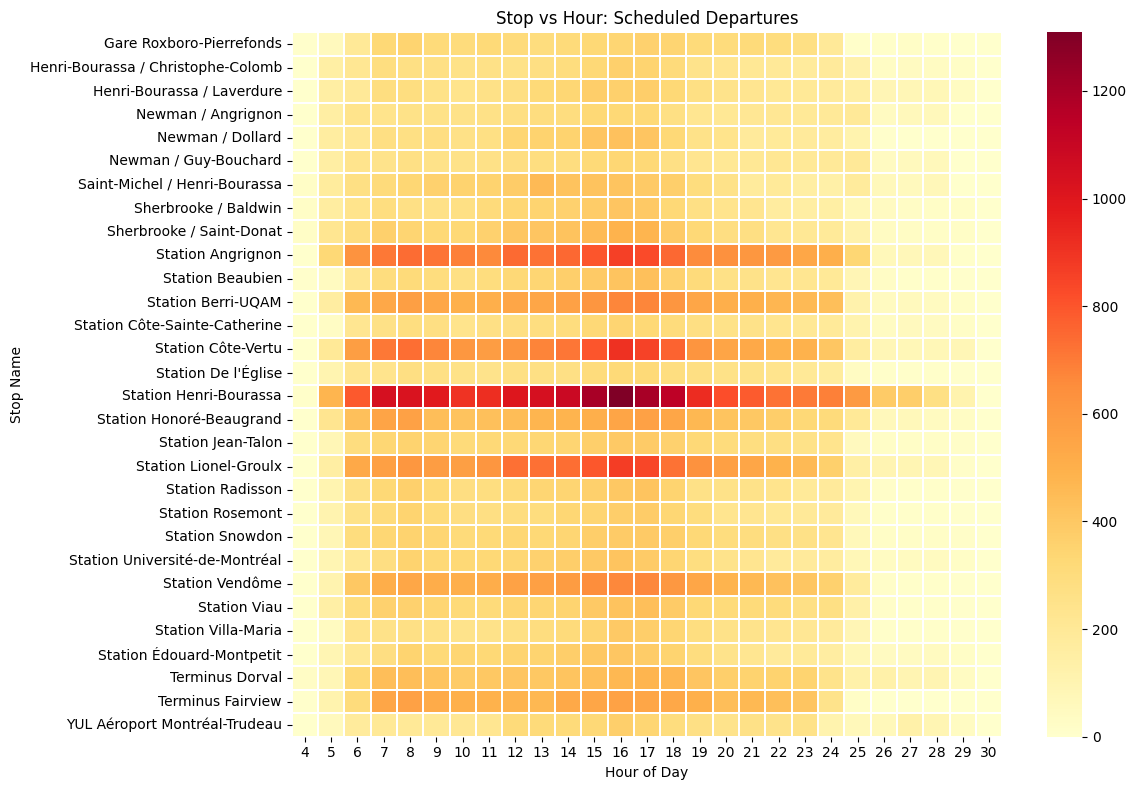

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.2)
plt.title("Stop vs Hour: Scheduled Departures")
plt.xlabel("Hour of Day")
plt.ylabel("Stop Name")
plt.tight_layout()
plt.show()

# ML Modelling & Prediction

In [34]:
top_stops_df.columns

Index(['stop_id', 'stop_name', 'hour', 'num_departures', 'smoothed',
       'busiest_hour'],
      dtype='object')

In [35]:
top_stops_df.shape

(69, 6)

## Temporal Feature Engineering

Although our data is not time series data at this point (calender.txt is not merged yet), we can treat it as such meaning we can treat each stop's hourly service pattern as a synthetic time series for modeling purposes. we can create lag features as we expect the current hour's value to depend on the previous hour’s. 

In [36]:
# Sort values
top_stops_df = top_stops_df.sort_values(["stop_id", "hour"])

# Lag features (previous hour’s departures)
top_stops_df["lag_1"] = top_stops_df.groupby("stop_id")["num_departures"].shift(1)
top_stops_df["lag_2"] = top_stops_df.groupby("stop_id")["num_departures"].shift(2)

we cannot use the smoothed feature we created previously as it was calculated using a centred rolling mean which will result in data leakage when it comes to forecasting. Here, we create another smoothed(rolling) feature using only the past hours.

In [37]:
top_stops_df.drop(columns=["smoothed"], inplace= True)

When using rolling as a feature, we want it to capture meaningful trends.(3-4 hours is balanced). If it is too small(2 hours), it may not add value and too large(4+ hours) window may over-smooth and wash out important local variations. However, as we will use tree-based models for forecasting, we create features with multiple window(2-3-4 hours) and let the model choose the most contributing features. 

In [38]:
# Simple rolling average
top_stops_df["rolling_2h"] = top_stops_df.groupby("stop_id")["num_departures"].rolling(window=2).mean().reset_index(level=0, drop=True)
top_stops_df["rolling_3h"] = top_stops_df.groupby("stop_id")["num_departures"].rolling(window=3).mean().reset_index(level=0, drop=True)
top_stops_df["rolling_4h"] = top_stops_df.groupby("stop_id")["num_departures"].rolling(window=4).mean().reset_index(level=0, drop=True)

# Drop rows with NaNs caused by shift/rolling (not the best approach!)
top_stops_df = top_stops_df.dropna(subset=["lag_1", "lag_2", "rolling_3h"])

The busiest_hour feature, by itself, is static and doesn't vary by hour, so it’s not directly useful in time-based modeling.
However, we can extract a more dynamic boolean feature from it, indicating whether the current hour is the busiest hour for that stop, which may help the model capture peak activity patterns.

In [39]:
top_stops_df["is_busiest_hour"] = (top_stops_df["hour"] == top_stops_df["busiest_hour"]).astype(int)

In [40]:
top_stops_df["stop_id"].nunique()

3

In [41]:
top_stops_df.columns

Index(['stop_id', 'stop_name', 'hour', 'num_departures', 'busiest_hour',
       'lag_1', 'lag_2', 'rolling_2h', 'rolling_3h', 'rolling_4h',
       'is_busiest_hour'],
      dtype='object')

It's time to merge the engineered dataset back to the original one. First, we make sure stop_id and hour features have the same format in both datasets.

In [42]:
full_schedule_df["stop_id"] = full_schedule_df["stop_id"].astype(str)
top_stops_df["stop_id"] = top_stops_df["stop_id"].astype(str)

# Creating "hour" in the main dataset 
full_schedule_df["hour"] = full_schedule_df["departure_time"].str.slice(0, 2).astype("int32")

In [43]:
# As the data in top_stops_df_model is aggregated by both stop and hour, we need to use both when merging datasets
df = pd.merge(
    full_schedule_df,
    top_stops_df[["stop_id", "hour", "num_departures", "rolling_2h", "rolling_3h", "rolling_4h", "lag_1", "lag_2", "busiest_hour", "is_busiest_hour"]],
    on=["stop_id", "hour"],
    how="left")

In [44]:
df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'agency_id', 'route_short_name',
       'route_long_name', 'route_type', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'location_type', 'parent_station', 'wheelchair_boarding',
       'hour', 'hour_mod', 'num_departures', 'rolling_2h', 'rolling_3h',
       'rolling_4h', 'lag_1', 'lag_2', 'busiest_hour', 'is_busiest_hour'],
      dtype='object')

Right now, df has one row per trip, this is fine for individual trip-level modeling, but it’s not yet ready for forecasting number of departures per hour unless we first aggregate df to this level (we will forecast hourly departure volume).

In [45]:
top_stop_ids = top_stops_df["stop_id"].unique()

In [46]:
df_top = df[df["stop_id"].isin(top_stop_ids)]

In [47]:
#df_top.columns

In [48]:
# Aggregate the dataset to have one row per (stop_id, hour)
# For each column, take the first value within each group
df_model = df_top.groupby(["stop_id", "hour"]).agg({
    'route_id': 'first',
    'service_id': 'first',
    'trip_headsign': 'first',
    'direction_id': 'first',
    'shape_id': 'first',
    'wheelchair_accessible': 'first',
    'agency_id': 'first',
    'route_short_name': 'first',
    'route_long_name': 'first',
    'route_type': 'first',
    'stop_code': 'first',
    'stop_name': 'first',
    'stop_lat': 'first',
    'stop_lon': 'first',
    'location_type': 'first',
    'parent_station': 'first',
    'wheelchair_boarding': 'first',
    'hour_mod': 'first',
    'num_departures': 'first',
    'rolling_2h': 'first',
    'rolling_3h': 'first',
    'rolling_4h': 'first',
    'lag_1': 'first',
    'lag_2': 'first',
    'busiest_hour': 'first',
    'is_busiest_hour': 'first'
}).reset_index()

In [49]:
df_model.groupby("stop_id")["hour"].nunique()

stop_id
36       25
54127    22
60633    22
Name: hour, dtype: int64

In [50]:
df_model.columns

Index(['stop_id', 'hour', 'route_id', 'service_id', 'trip_headsign',
       'direction_id', 'shape_id', 'wheelchair_accessible', 'agency_id',
       'route_short_name', 'route_long_name', 'route_type', 'stop_code',
       'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'wheelchair_boarding', 'hour_mod', 'num_departures', 'rolling_2h',
       'rolling_3h', 'rolling_4h', 'lag_1', 'lag_2', 'busiest_hour',
       'is_busiest_hour'],
      dtype='object')

<span style="font-size:18px">**Note**

Since we're treating hours of the day as time series data, we can't just split the train and test sets randomly. Instead, we’re using the earlier hours to forecast the tail end of the service day. We’re skipping late-night and post-midnight hours for now, since their behavior is quite different from the rest of the day. These could be included in future analyses once we bring in full datetime info, things like day of the week or time of month would give more context to help model those off-hours more accurately.

In [51]:
# Split by hour (train: 4–20, test: 21–24)
train_df = df_model[df_model["hour"].between(4, 20)]
test_df = df_model[df_model["hour"].between(21, 24)]

**Reasons to use all features:** We’re using a tree-based model (like Random Forest or XGBoost), which handles, mixed types (numeric + categorical), redundant features, and unimportant features. We let the model decide what’s important.

In [52]:
features  = ['stop_id', 'hour', 'direction_id', 'route_type',
            'wheelchair_accessible', 'location_type', 'wheelchair_boarding',
            'hour_mod', 'rolling_2h', 'rolling_3h', 'rolling_4h',
            'lag_1', 'lag_2', 'busiest_hour', 'is_busiest_hour']

target = "num_departures"

In [53]:
train_df = train_df.dropna(subset=["num_departures"])
test_df = test_df.dropna(subset=["num_departures"])

# Prepare inputs
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

In [54]:
print(y_train.isna().sum(), "missing values in y_train")
print(X_train.isna().sum().sum(), "missing values in X_train")

0 missing values in y_train
3 missing values in X_train


## Model Training and Evaluation

<span style="font-size:20px">**Forecasting Goal and Scope Reminder**

The goal of this forecasting task is not to build a comprehensive model over the entire dataset, but rather to demonstrate a practical application of predictive modeling. We focus on a pretty small subset of the data and forecast the number of scheduled departures at each hour of the day.

Given the small size and low complexity of the dataset, we intentionally do not deep-dive into model optimization. This includes skipping validation set creation, cross-validation, hyperparameter tuning, or advanced models.

Instead, the objective is to showcase a solid understanding of the prediction pipeline, from data preprocessing and feature engineering to model training and evaluation, using interpretable techniques like Random Forests and clear visualizations.

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [56]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 23.95
RMSE: 33.76


<span style="font-size:18px">**Error Interpretation:**

MAE: 23.95

On average, the model is off by about 24 departures per hour at each stop.

RMSE: 33.76

The model’s typical error magnitude is ~34 departures, with more weight on large mistakes.

## Feature Importance

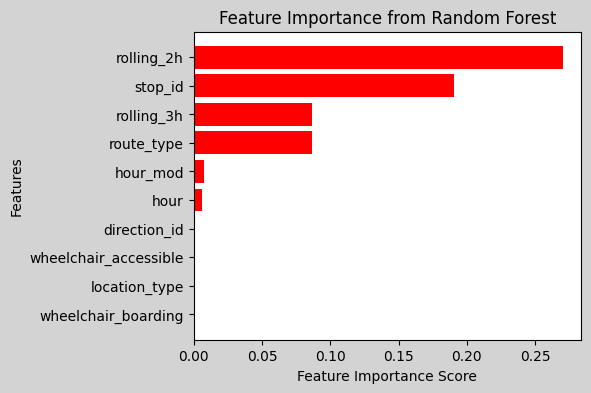

In [57]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.head(10)
# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(5,4), facecolor="lightgray")
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='red')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')

# Display the highest importance at the top
plt.gca().invert_yaxis()
plt.show()

<span style="font-size:18px">**Feature Importance Insights:**

The most predictive feature is rolling_2h, suggesting that short-term historical averages are highly effective.

stop_id ranking high shows that location-specific patterns dominate forecasting.

lag_1 and busiest_hour also help, indicating that recent values and knowledge of peak time are meaningful.

Accessibility-related features contributed almost nothing to predicting volume.

## Plotting Model Behavior

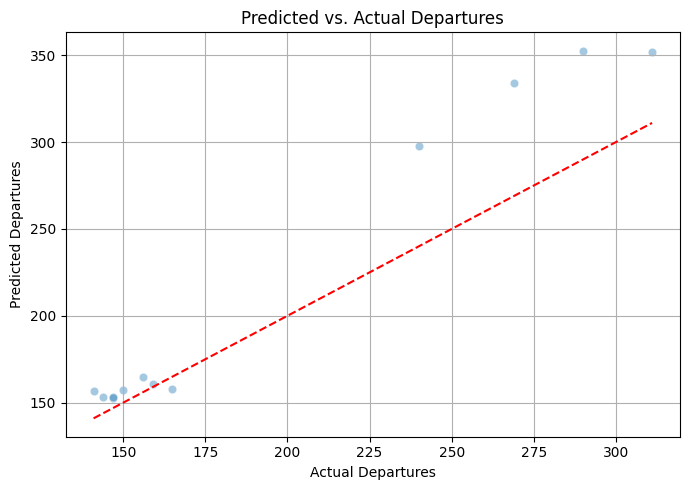

In [58]:
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Departures")
plt.ylabel("Predicted Departures")
plt.title("Predicted vs. Actual Departures")
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="font-size:18px">**How to read the plot:**

Blue dots: Each dot is one prediction.

- X-axis: the true number of departures
- Y-axis: what the model predicted

Red dashed line: The "perfect prediction line."

Several blue spots are close to the red line at the start, but drift away further down. Which means:

- The model does better at predicting low departure volumes, but it struggles more as the actual number increases, possibly underestimating higher values.

# Next Steps

This project focused on forecasting hourly departures at busy stops using GTFS data. To take it further, we could:

1. **Add More Time Context**

Include weekday/weekend info using GTFS calendar files.

Use actual timestamps for better time-series modeling.

2. **Scale to More Stops**

Apply forecasting to more stops or the full network.

Group similar stops and build general models.

3. **Predict More Targets**

Try new ML tasks like predicting delays, crowding, or accessibility issues.

4. **Try Other Models**

Test models like XGBoost, ARIMA, or even deep learning (if data grows).

5. **Improve Evaluation**

Use cross-validation and focus on business-relevant metrics (like accuracy during rush hour).

<span style="font-size:20px">**Summary**

This forecasting model is a starting point. It can grow into a more advanced pipeline to help improve service reliability, accessibility, and planning.

## Preparing Data for SQL-based Analysis & Tableau Visualizaton 

**Merging calender to the current data**

In [59]:
full_schedule_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'agency_id', 'route_short_name',
       'route_long_name', 'route_type', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'location_type', 'parent_station', 'wheelchair_boarding',
       'hour', 'hour_mod'],
      dtype='object')

In [60]:
# Load calendar and trips data
calendar = gtfs_dfs["calendar"]
trips = gtfs_dfs["trips"]

# Merge trips with calendar on service_id
trips_with_days = pd.merge(trips, calendar, on="service_id", how="left")

weekday_cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
full_schedule_df = full_schedule_df.drop(columns=[col for col in weekday_cols if col in full_schedule_df.columns])

# Merge the weekday info back into the full schedule
full_schedule_gtfs = pd.merge(
    full_schedule_df,
    trips_with_days[["trip_id", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]],
    on="trip_id",
    how="left"
)

In [61]:
columns_to_exclude_tableau=["parent_station", "arrival_time", "hour_mod", "service_id", "shape_id", \
                            "stop_sequence", "location_type", "num_departures"]

In [62]:
keep = ['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'route_id', 'route_short_name',
             'route_long_name', 'route_type', 'departure_time', 'hour', 
             'wheelchair_boarding', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
            'trip_id', 'trip_headsign', 'direction_id', 'agency_id', 'stop_code', 'wheelchair_accessible']

In [63]:
# Count how many departures (rows) happen at each stop overall 
busiest_stops = full_schedule_gtfs.groupby("stop_id")["departure_time"].count().sort_values(ascending=False).head(30).index

In [64]:
df_30_top_stops = full_schedule_gtfs[full_schedule_gtfs["stop_id"].isin(busiest_stops)]

In [65]:
df_30_top_stops.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'route_id', 'service_id', 'trip_headsign', 'direction_id', 'shape_id',
       'wheelchair_accessible', 'agency_id', 'route_short_name',
       'route_long_name', 'route_type', 'stop_code', 'stop_name', 'stop_lat',
       'stop_lon', 'location_type', 'parent_station', 'wheelchair_boarding',
       'hour', 'hour_mod', 'monday', 'tuesday', 'wednesday', 'thursday',
       'friday', 'saturday', 'sunday'],
      dtype='object')

In [66]:
df_30_top_stops.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107548 entries, 8770 to 6261234
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trip_id                107548 non-null  int64  
 1   arrival_time           107548 non-null  object 
 2   departure_time         107548 non-null  object 
 3   stop_id                107548 non-null  object 
 4   stop_sequence          107548 non-null  int64  
 5   route_id               107548 non-null  int64  
 6   service_id             107548 non-null  object 
 7   trip_headsign          107548 non-null  object 
 8   direction_id           107548 non-null  int64  
 9   shape_id               107548 non-null  int64  
 10  wheelchair_accessible  107548 non-null  int64  
 11  agency_id              107548 non-null  object 
 12  route_short_name       107548 non-null  int64  
 13  route_long_name        107548 non-null  object 
 14  route_type             107548 non-nul

In [67]:
df_30_top_stops = df_30_top_stops[keep]

In [68]:
df_30_top_stops.to_csv('gtfs_selective_columns.csv', index=False)